In [1]:
from pylab import *
from astropy.convolution import convolve
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import numpy as np
ion()

# MIRMOS internal performance

In [2]:

_ = np.array

ls = _([0.975, 0.985, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4])
val = _([0.616, 0.654, 0.695, 0.705, 0.703, 0.694, 0.702, 0.723, 0.726, 0.704, 0.682, 0.683, 
         0.691, 0.708, 0.648, 0.581, 0.576])

## val is what's expected across the full train

adcs = _([0.9681, 0.9724, 0.9787, 0.9530, 0.9303, 0.9461, 0.9635, 0.9628, 0.9518, 0.9452, 0.9465, 0.9555, 0.9671,
       0.9797, 0.9829, 0.9813, 0.9683])

dichroics = adcs.copy()
dichroics[:] = 0.95




In [3]:
detl = _([0.8, 1.0, 1.23, 2.0, 2.5])
detqe = _([0.95, 0.83, 0.87, 0.88, 0.9])

def fdetqe(l):
    return np.interp(l, detl, detqe)


In [4]:
def flyot(l):
    r = np.ones_like(l)
    r[l>2.0] = 0.95
    
    return r

In [5]:
def mirrors(l):
    return 0.9**3

In [6]:
def grating(l):
    return 0.85

# Atmospheric Throughput

In [7]:
try:
    dat1
except:
    dat1 = np.loadtxt("atran.smo.12555.dat.txt")
    dat2 = np.loadtxt("atran.smo.12560.dat.txt")

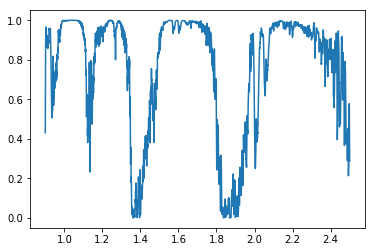

In [8]:
_, latm1, tatm1 = dat1.T
_, latm2, tatm2 = dat2.T

latm = np.concatenate([latm2, latm1])
tatm = np.concatenate([tatm2, tatm1])

latm.shape

box_kernel = Box1DKernel(355)
plot(latm, convolve(tatm, box_kernel));

# Now put it all together

/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


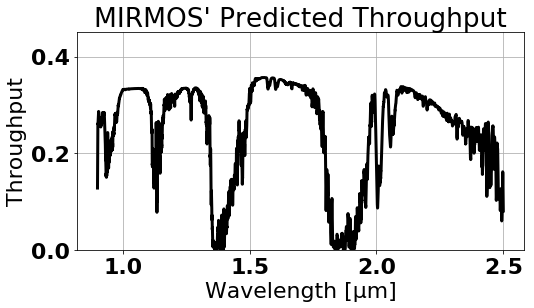

In [10]:
figure(figsize=(8,4))


def end2end(l):
    return np.interp(l, ls, val*adcs*dichroics*fdetqe(ls)*flyot(ls)*mirrors(ls)*grating(ls))


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc("font", **font)

plot(latm,
     end2end(latm)*convolve(tatm, box_kernel),
    color='black', lw=3)

#step(latm, tatm, alpha=0.5)


grid(True)
ylim(0,0.45)
title("MIRMOS' Predicted Throughput")
xlabel("Wavelength [µm]")
ylabel("Throughput")
show()



# Internal Transmission

In [11]:
# From MOSFIRE
# wavelength, infrasil, znse, caf2, Baf2, s-ftm16, s-fpl51
# These are internal transmissions (ignoring fresnel) for 25-mm thickness

perf = '''0.975     0.9970   0.9970   0.9717   0.9970   0.9929   0.9867
  0.985     0.9970   0.9970   0.9725   0.9970   0.9930   0.9868
  1.000     0.9970   0.9970   0.9736   0.9970   0.9932   0.9872
  1.100     0.9970   0.9970   0.9799   0.9970   0.9938   0.9877
  1.200     0.9970   0.9970   0.9843   0.9970   0.9937   0.9894
  1.300     0.9970   0.9970   0.9875   0.9970   0.9937   0.9899
  1.400     0.9970   0.9970   0.9899   0.9970   0.9868   0.9918
  1.500     0.9970   0.9970   0.9917   0.9970   0.9835   0.9901
  1.600     0.9970   0.9970   0.9931   0.9970   0.9778   0.9901
  1.700     0.9970   0.9970   0.9942   0.9970   0.9681   0.9895
  1.800     0.9970   0.9970   0.9951   0.9970   0.9620   0.9888
  1.900     0.9970   0.9970   0.9958   0.9970   0.9632   0.9887
  2.000     0.9970   0.9970   0.9963   0.9970   0.9584   0.9867
  2.100     0.9970   0.9970   0.9968   0.9970   0.9494   0.9860
  2.200     0.9970   0.9970   0.9972   0.9970   0.8865   0.9814
  2.300     0.9970   0.9970   0.9975   0.9970   0.8322   0.9798
  2.400     0.9970   0.9970   0.9977   0.9970   0.8634   0.9797'''

In [12]:
ar = []
for line in perf.split("\n"):
    ar.append(list(map(float, line.split())))

ar = np.array(ar)

kwave, tinfrasil, tcaf2, tznse, tbaf2, tsftm16, tsfpl51 = ar.T
_, ksio2, kcaf2, kznse, kbaf2, kstfm16, ksfpl51 = -np.log10(ar.T)/25.


# Above are in units of mm^(-1)

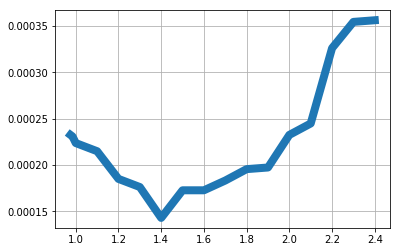

In [13]:
plot(kwave, ksfpl51, lw=8)
grid(True)
show()

In [20]:
# 10**(-k*10)==0.8675
k = -np.log10(0.8675)/10
print( 10**(-k*20), " should equal ", 0.75282)


0.75255625  should equal  0.75282


In [21]:
def transmission(l, thickness_mm, kwave, k25mm):
    """ Return transmission at l for a sample that is thickness_mm thick measured at wavelengths kwave and coefficients k25mm"""
    k_at_l = np.interp(l, kwave, k25mm)
    return 10**(-k_at_l * thickness_mm)
    

In [22]:

print(tznse[0], " should equal ", transmission(kwave[0], 25, kwave, kznse))

0.9717  should equal  0.9717


# AR Coating Performance

In [23]:

coat_txt = '''0.975   0.9681   0.9714   0.9731   0.9884   0.9476   0.9756   0.9750   0.9906
0.985   0.9724   0.9716   0.9737   0.9896   0.9539   0.9814   0.9765   0.9909
1.000   0.9787   0.9720   0.9744   0.9895   0.9644   0.9882   0.9772   0.9894
1.100   0.9530   0.9730   0.9772   0.9805   0.9937   0.9865   0.9809   0.9869
1.200   0.9303   0.9774   0.9822   0.9903   0.9922   0.9928   0.9769   0.9927
1.300   0.9461   0.9733   0.9848   0.9856   0.9827   0.9889   0.9789   0.9861
1.400   0.9635   0.9725   0.9862   0.9798   0.9766   0.9836   0.9828   0.9816
1.500   0.9628   0.9783   0.9869   0.9806   0.9762   0.9832   0.9861   0.9820
1.600   0.9518   0.9838   0.9885   0.9835   0.9795   0.9850   0.9874   0.9842
1.700   0.9452   0.9840   0.9901   0.9840   0.9850   0.9852   0.9861   0.9834
1.800   0.9465   0.9805   0.9925   0.9799   0.9900   0.9849   0.9839   0.9811
1.900   0.9555   0.9765   0.9931   0.9777   0.9935   0.9846   0.9823   0.9810
2.000   0.9671   0.9755   0.9938   0.9779   0.9948   0.9854   0.9826   0.9812
2.100   0.9797   0.9770   0.9946   0.9801   0.9938   0.9873   0.9846   0.9828
2.200   0.9829   0.9789   0.9952   0.9821   0.9907   0.9884   0.9856   0.9842
2.300   0.9813   0.9795   0.9956   0.9829   0.9854   0.9879   0.9849   0.9848
2.400   0.9683   0.9774   0.9960   0.9811   0.9794   0.9829   0.9816   0.9820
'''

In [24]:
ar = []
for line in perf.split("\n"):
    ar.append(list(map(float, line.split())))

ar = np.array(ar)

kwave, tinfrasil, tcaf2, tznse, tbaf2, tsftm16, tsfpl51 = ar.T
_, ksio2, kcaf2, kznse, kbaf2, kstfm16, ksfpl51 = -np.log10(ar.T)/25.


# Above are in units of mm^(-1)